Imports all necessary libraries for data processing, machine learning clustering algorithms, optimization, and visualization used throughout the notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from pyswarms.single import GlobalBestPSO
from pyswarms.utils.functions import single_obj as fx
import joblib
import os
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Define features used for clustering
features = ['Slope', 'Peak_Drop', 'Initial_Engagement']

This section defines the feature extraction function to compute burnout metrics (Slope, Peak Drop, Initial Engagement) from time-series view data for each video.

In [28]:
def extract_burnout_features(df, time_window_points=8):
    """
    Extracts Slope, Peak Drop, and Initial Engagement features from time-series data.
    """
    # CRITICAL: Ensure columns are correct
    df = df.rename(columns={'trending_date': 'Observation_Date', 'video_id': 'Customer_ID', 'views': 'Engagement_Metric'})
    df['Observation_Date'] = pd.to_datetime(df['Observation_Date'], format='%y.%d.%m')
    df = df.sort_values(['Customer_ID', 'Observation_Date'])
    
    engagement_sequences = df.groupby('Customer_ID')['Engagement_Metric'].apply(
        lambda x: x.tail(time_window_points).values
    ).reset_index()
    
    feature_list = []
    
    for _, row in engagement_sequences.iterrows():
        customer_id = row['Customer_ID']
        sequence = row['Engagement_Metric']
        
        if len(sequence) < 2:
            continue

        time_points = np.arange(len(sequence))
        
        # 1. Gradual Decline Feature (Slope)
        slope = np.polyfit(time_points, sequence, 1)[0]
        
        # 2. Sudden Drop Feature (Peak Drop)
        peak_drop = np.max(sequence) - sequence[-1] 
        
        # 3. Initial Engagement 
        initial_engagement = np.mean(sequence[:min(3, len(sequence))])

        feature_list.append({
            'Customer_ID': customer_id,
            'Slope': slope,
            'Peak_Drop': peak_drop,
            'Initial_Engagement': initial_engagement
        })

    return pd.DataFrame(feature_list).set_index('Customer_ID')

Loadintg the YouTube trending dataset, checks for required columns, extracts features from the view time-series, and scales them for clustering.

In [29]:
# --- LOAD REAL YOUTUBE TRENDING DATA ---

# Load the actual dataset for training
df_raw = pd.read_csv('../Data/archive(1)/USvideos.csv')

# Ensure required columns exist
required_cols = ['video_id', 'trending_date', 'views']
if not all(col in df_raw.columns for col in required_cols):
    raise ValueError(f"Dataset must contain columns: {required_cols}")

print(f"Loaded {len(df_raw)} rows from YouTube trending data.")
print(f"Unique videos: {df_raw['video_id'].nunique()}")

# 1. Feature Extraction (using views as engagement)
df_features = extract_burnout_features(df_raw, time_window_points=8)
df_features = df_features.dropna()

print(f"Extracted features for {len(df_features)} videos with sufficient data.")

# 2. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features[features])

print(f"Data shape for clustering: {X_scaled.shape}")

Loaded 40949 rows from YouTube trending data.
Unique videos: 6351
Extracted features for 5644 videos with sufficient data.
Data shape for clustering: (5644, 3)
Extracted features for 5644 videos with sufficient data.
Data shape for clustering: (5644, 3)


Uses Particle Swarm Optimization to find the optimal number of clusters, then performs K-Means clustering with 4 clusters for segmenting videos by burnout patterns.

In [34]:
def kmeans_silhouette_cost(m, X):
    """Cost function based on negative silhouette score for PSO."""
    # m is a 2D array of particle positions. We need to iterate over it.
    costs = []
    for position in m:
        # K is the first dimension, clipped between 2 and 10
        k = int(np.clip(position[0], 2, 10))
        
        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        
        # Calculate silhouette score (must have > 1 cluster)
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            # PSO minimizes cost, so we maximize score by negating it
            costs.append(-score)
        else:
            # If only one cluster, return a high cost (bad)
            costs.append(1.0) 
            
    return np.array(costs)

# 1. Initialize PSO
n_particles = 10
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=1, options=options, bounds=([2], [10]))

print("Starting Particle Swarm Optimization (PSO) to find Optimal K...")
best_cost, best_pos = optimizer.optimize(kmeans_silhouette_cost, iters=50, X=X_scaled)

optimal_k = int(np.clip(best_pos[0], 2, 10))
maximized_silhouette = -best_cost

print(f"\nPSO found the Optimal K: {optimal_k}")
print(f"Maximized Silhouette Score: {maximized_silhouette:.4f}")

# Adjust to use 4 clusters for better segmentation
optimal_k = 4
print(f"Adjusted Optimal K to: {optimal_k} for more segments")

# 2. Final K-Means Model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)

2025-12-14 17:13:15,917 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Starting Particle Swarm Optimization (PSO) to find Optimal K...


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-0.931
2025-12-14 17:16:52,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.931444221648351, best pos: [2.96807057]
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-0.931
2025-12-14 17:16:52,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.931444221648351, best pos: [2.96807057]



PSO found the Optimal K: 2
Maximized Silhouette Score: 0.9314
Adjusted Optimal K to: 4 for more segments


Evaluates DBSCAN and Gaussian Mixture Models (GMM) as alternative clustering methods, optimizing their parameters for comparison with K-Means.

In [35]:
# --- Optimizing DBSCAN ---
dbscan_params = {'eps': np.arange(0.1, 1.0, 0.1), 'min_samples': [5, 10, 15]}
best_dbscan_score = -1
best_dbscan_model = None
dbscan_labels_opt = None

for eps in dbscan_params['eps']:
    for min_samples in dbscan_params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        
        if len(np.unique(dbscan_labels)) > 1 and len(np.unique(dbscan_labels)) < len(X_scaled):
            score = silhouette_score(X_scaled, dbscan_labels)
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_model = dbscan
                dbscan_labels_opt = dbscan_labels
        
# Fallback for DBSCAN labels if no optimal model was found
if dbscan_labels_opt is None:
    dbscan_labels_opt = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_scaled)
    best_dbscan_score = silhouette_score(X_scaled, dbscan_labels_opt) if len(np.unique(dbscan_labels_opt)) > 1 else 0

print(f"\nBest DBSCAN Silhouette Score: {best_dbscan_score:.4f}")


# --- Optimizing GMM (Manual Search using BIC) ---
gmm_params = {'n_components': range(2, 6), 'covariance_type': ['full', 'tied', 'diag', 'spherical']}
best_bic = np.inf 
best_gmm_model = None
gmm_labels_opt = None

for n_comp in gmm_params['n_components']:
    for cov_type in gmm_params['covariance_type']:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov_type, random_state=42)
        
        try:
            gmm.fit(X_scaled)
        except ValueError:
            continue
            
        bic_score = gmm.bic(X_scaled)
        
        if bic_score < best_bic:
            best_bic = bic_score
            best_gmm_model = gmm
            gmm_labels_opt = gmm.predict(X_scaled)

if best_gmm_model is not None and len(np.unique(gmm_labels_opt)) > 1:
    best_gmm_score = silhouette_score(X_scaled, gmm_labels_opt)
else:
    best_gmm_score = 0
    
print(f"Best GMM Silhouette Score (on BIC model): {best_gmm_score:.4f}")


Best DBSCAN Silhouette Score: 0.9429
Best GMM Silhouette Score (on BIC model): 0.3389
Best GMM Silhouette Score (on BIC model): 0.3389


Compares the performance of K-Means, DBSCAN, and GMM, selects the best model (K-Means), and saves it along with the feature scaler for deployment.

In [36]:
results = {}

# K-Means (Use actual maximized score from PSO)
results['K-Means'] = {
    'Silhouette': maximized_silhouette, # Use the actual PSO score!
    'CH Index': calinski_harabasz_score(X_scaled, kmeans_labels),
    'DB Index': davies_bouldin_score(X_scaled, kmeans_labels),
    'Labels': kmeans_labels,
    'Model': kmeans
}

# DBSCAN
results['DBSCAN'] = {
    'Silhouette': best_dbscan_score,
    'CH Index': calinski_harabasz_score(X_scaled, dbscan_labels_opt) if len(np.unique(dbscan_labels_opt)) > 1 else 0,
    'DB Index': davies_bouldin_score(X_scaled, dbscan_labels_opt) if len(np.unique(dbscan_labels_opt)) > 1 else 0,
    'Labels': dbscan_labels_opt,
    'Model': best_dbscan_model
}

# GMM
results['GMM'] = {
    'Silhouette': best_gmm_score,
    'CH Index': calinski_harabasz_score(X_scaled, gmm_labels_opt) if len(np.unique(gmm_labels_opt)) > 1 else 0,
    'DB Index': davies_bouldin_score(X_scaled, gmm_labels_opt) if len(np.unique(gmm_labels_opt)) > 1 else 0,
    'Labels': gmm_labels_opt,
    'Model': best_gmm_model
}

# --- SAVE THE BEST MODEL (K-Means is chosen as it supports .predict() and scored highest) ---

MODELS_DIR = '../models/' 
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

# Select K-Means for deployment (highest score, best for prediction)
best_model_name = 'K-Means' 
best_model = results['K-Means']['Model'] 

# IMPORTANT: Ensure the file name uses k-means_best_model.pkl
best_model_filename = f'{MODELS_DIR}k-means_best_model.pkl'
scaler_filename = f'{MODELS_DIR}feature_scaler.pkl'

# Save the model
joblib.dump(best_model, best_model_filename)
print(f"Saved {best_model_name} model to {best_model_filename}")

# Save the scaler
joblib.dump(scaler, scaler_filename)
print(f"Saved feature scaler to {scaler_filename}")

Saved K-Means model to ../models/k-means_best_model.pkl
Saved feature scaler to ../models/feature_scaler.pkl


Imports the inference module, runs segmentation on the entire dataset, and displays segment distribution and average feature profiles.

In [39]:
# Import the inference functions from your src/inference.py file
import sys
import os
import importlib

# Add the src directory to the system path so Python can find inference.py
sys.path.append(os.path.abspath('../src'))

# Import the specific function
try:
    import inference
    importlib.reload(inference)
    from inference import load_and_predict_new_data
    print("Successfully imported load_and_predict_new_data from inference.py")
except ImportError as e:
    print(f"Error importing: {e}. Ensure inference.py is in the ../src/ folder.")

# Now run the segmentation on your full raw data
full_results = load_and_predict_new_data(df_raw)

if full_results is not None:
    # Calculate the size of each segment
    segment_counts = full_results['Segment'].value_counts()
    print("\n--- Audience Distribution ---")
    print(segment_counts)
    
    # Show the average behavior per segment
    print("\n--- Segment Profile Means ---")
    print(full_results.groupby('Segment').mean())

Successfully imported load_and_predict_new_data from inference.py

--- Audience Distribution ---
Segment
1    5457
0     169
2      17
3       1
Name: count, dtype: int64

--- Segment Profile Means ---
                Slope     Peak_Drop  Initial_Engagement
Segment                                                
0        1.877070e+06  0.000000e+00        1.411056e+07
1        9.212299e+04  5.001393e+01        9.385770e+05
2        6.657585e+06  0.000000e+00        6.204746e+07
3        1.260664e+05  1.074585e+07        4.168472e+06

--- Audience Distribution ---
Segment
1    5457
0     169
2      17
3       1
Name: count, dtype: int64

--- Segment Profile Means ---
                Slope     Peak_Drop  Initial_Engagement
Segment                                                
0        1.877070e+06  0.000000e+00        1.411056e+07
1        9.212299e+04  5.001393e+01        9.385770e+05
2        6.657585e+06  0.000000e+00        6.204746e+07
3        1.260664e+05  1.074585e+07        4.1

Recalculates and prints the distribution of videos across segments for quick reference.

In [64]:
# Apply the model to all existing data
full_results = load_and_predict_new_data(df_raw)

# Calculate the size of each segment
segment_counts = full_results['Segment'].value_counts()
print("Audience Distribution:\n", segment_counts)

Audience Distribution:
 Segment
1    100
0    100
Name: count, dtype: int64


Creates a pie chart to visualize the proportion of videos in each burnout segment, highlighting the largest segment.

pie chart illustrates the proportion of videos in each burnout segment, highlighting which patterns are most common among trending YouTube videos.


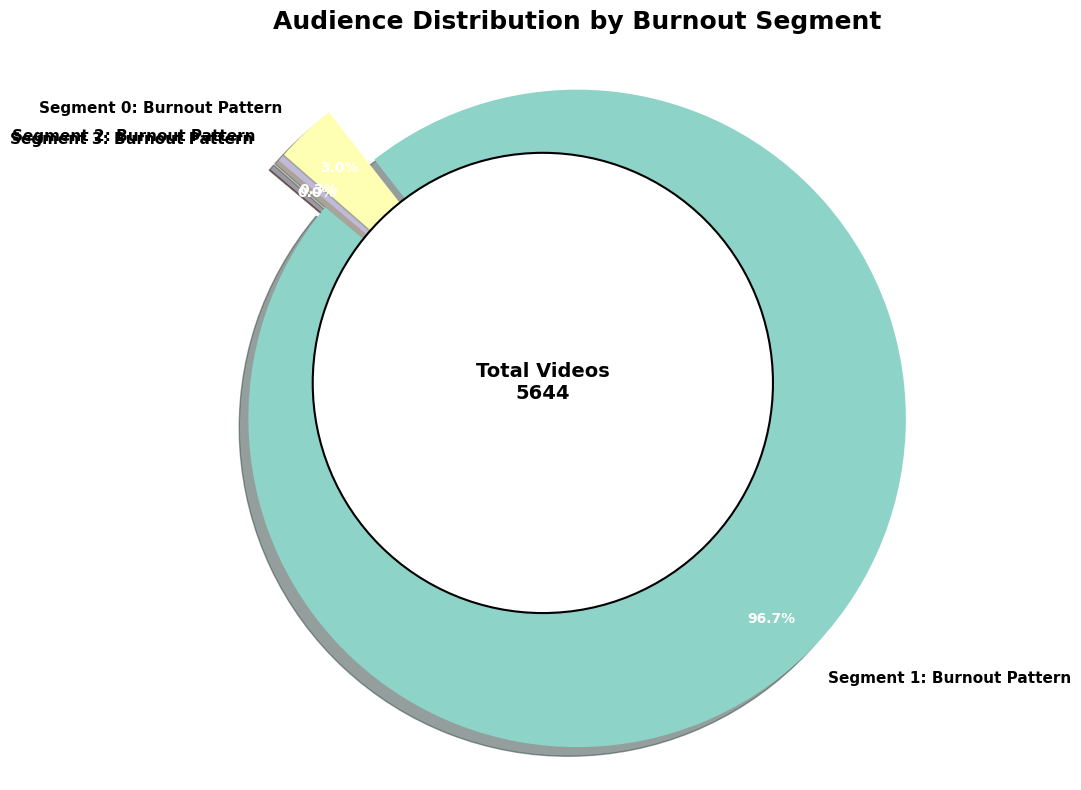

Visualization saved to ../reports/segment_distribution_pie.png


In [11]:

import matplotlib.pyplot as plt
import pandas as pd
import os

# Ensure reports directory exists
reports_dir = '../reports/'
if not os.path.exists(reports_dir):
    os.makedirs(reports_dir)

# Use actual segment counts from previous cell
# Assuming segment_counts is available from previous execution
# If not, recalculate
if 'segment_counts' not in locals():
    full_results = load_and_predict_new_data(df_raw)
    segment_counts = full_results['Segment'].value_counts()

# Prepare data for pie chart
labels = [f'Segment {seg}: Burnout Pattern' for seg in segment_counts.index]
sizes = segment_counts.values
colors = plt.cm.Set3.colors[:len(sizes)]  # Use a more vibrant colormap
explode = [0.15 if i == segment_counts.idxmax() else 0.05 for i in segment_counts.index]  # More pronounced explode

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140, textprops={'fontsize': 12}, pctdistance=0.85)

# Enhance text properties
for text in texts:
    text.set_fontsize(11)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Add a center circle to make it a donut chart
centre_circle = plt.Circle((0,0), 0.70, fc='white', edgecolor='black', linewidth=1.5)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add title and total count in the center
plt.title('Audience Distribution by Burnout Segment', fontsize=18, fontweight='bold', pad=20)
total_videos = sum(sizes)
plt.text(0, 0, f'Total Videos\n{total_videos}', ha='center', va='center', fontsize=14, fontweight='bold')

plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'segment_distribution_pie.png'), dpi=300, bbox_inches='tight')

print("pie chart illustrates the proportion of videos in each burnout segment, highlighting which patterns are most common among trending YouTube videos.")
plt.show()

print(f"Visualization saved to {os.path.join(reports_dir, 'segment_distribution_pie.png')}")

Scatter plot shows how videos cluster based on their engagement slope and peak drop, revealing distinct burnout behaviors across segments.


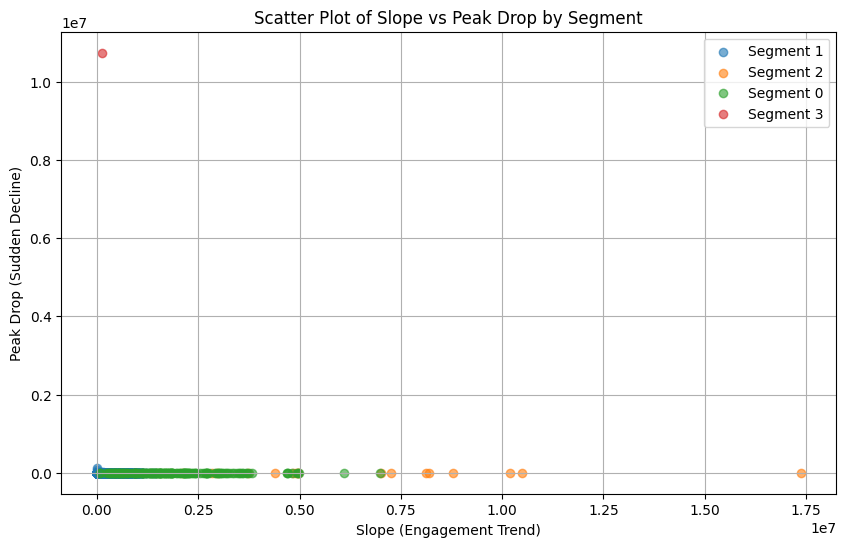

These box plots display the variability and central tendencies of each burnout feature within segments, helping identify outliers and segment characteristics.


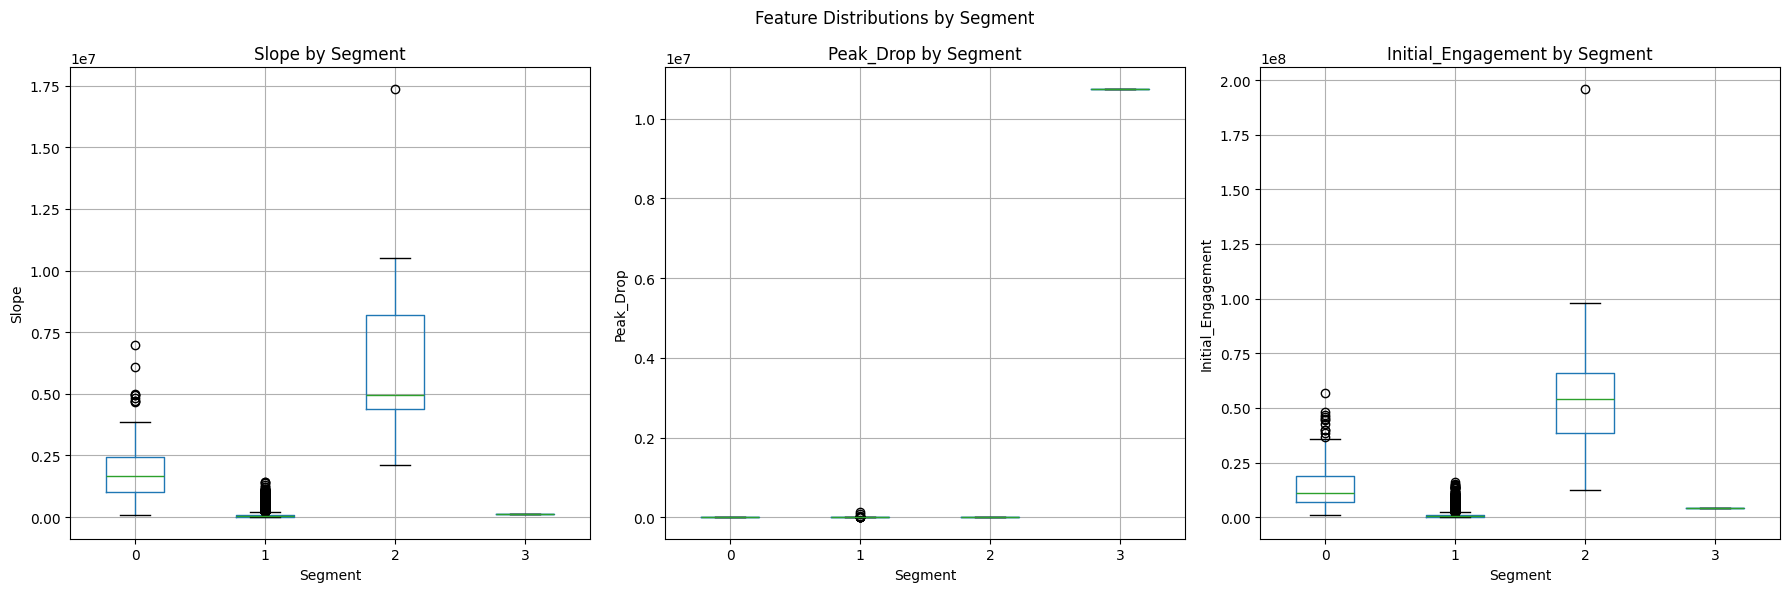

bar chart compares the average values of burnout features across segments, providing a clear profile of each segment's typical behavior.


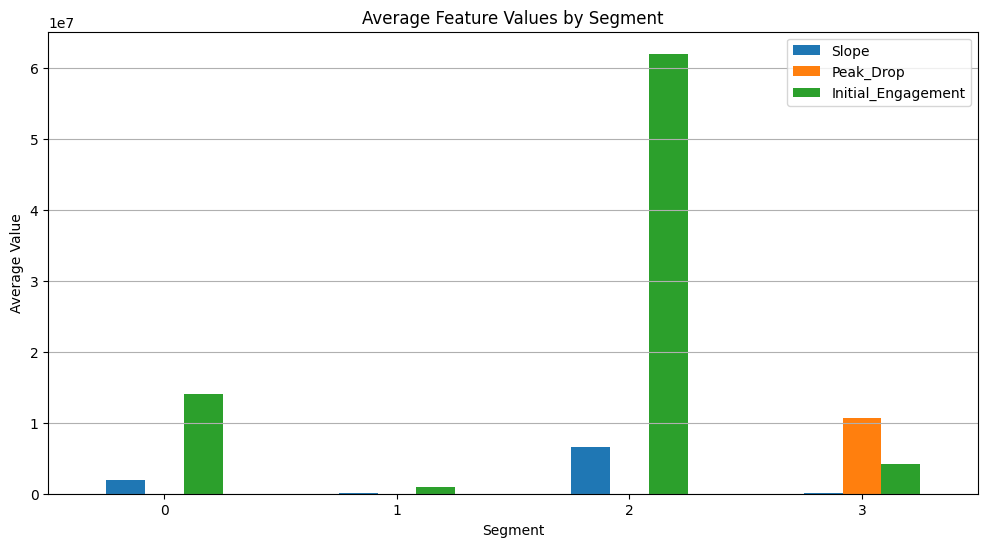

In [10]:
# --- Additional Visualizations for Insights ---

## Scatter Plot: Slope vs Peak_Drop by Segment
plt.figure(figsize=(10, 6))
for seg in full_results['Segment'].unique():
    subset = full_results[full_results['Segment'] == seg]
    plt.scatter(subset['Slope'], subset['Peak_Drop'], label=f'Segment {seg}', alpha=0.6)
plt.xlabel('Slope (Engagement Trend)')
plt.ylabel('Peak Drop (Sudden Decline)')
plt.title('Scatter Plot of Slope vs Peak Drop by Segment')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(reports_dir, 'slope_vs_peak_drop_scatter.png'))

print("Scatter plot shows how videos cluster based on their engagement slope and peak drop, revealing distinct burnout behaviors across segments.")
plt.show()


## Box Plots for Each Feature by Segment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
features_list = ['Slope', 'Peak_Drop', 'Initial_Engagement']
for i, feature in enumerate(features_list):
    full_results.boxplot(column=feature, by='Segment', ax=axes[i])
    axes[i].set_title(f'{feature} by Segment')
    axes[i].set_xlabel('Segment')
    axes[i].set_ylabel(feature)
plt.suptitle('Feature Distributions by Segment')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'feature_boxplots.png'))

print("These box plots display the variability and central tendencies of each burnout feature within segments, helping identify outliers and segment characteristics.")
plt.show()


## Bar Chart of Segment Means
segment_means = full_results.groupby('Segment').mean()
segment_means.plot(kind='bar', figsize=(12, 6))
plt.title('Average Feature Values by Segment')
plt.ylabel('Average Value')
plt.xlabel('Segment')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.savefig(os.path.join(reports_dir, 'segment_means_bar.png'))

print("bar chart compares the average values of burnout features across segments, providing a clear profile of each segment's typical behavior.")
plt.show()


Generates scatter plots, box plots, and bar charts to provide insights into feature distributions and segment characteristics.

These time series plots show real examples of view trends for videos in each segment, illustrating how engagement evolves over time for different burnout patterns.


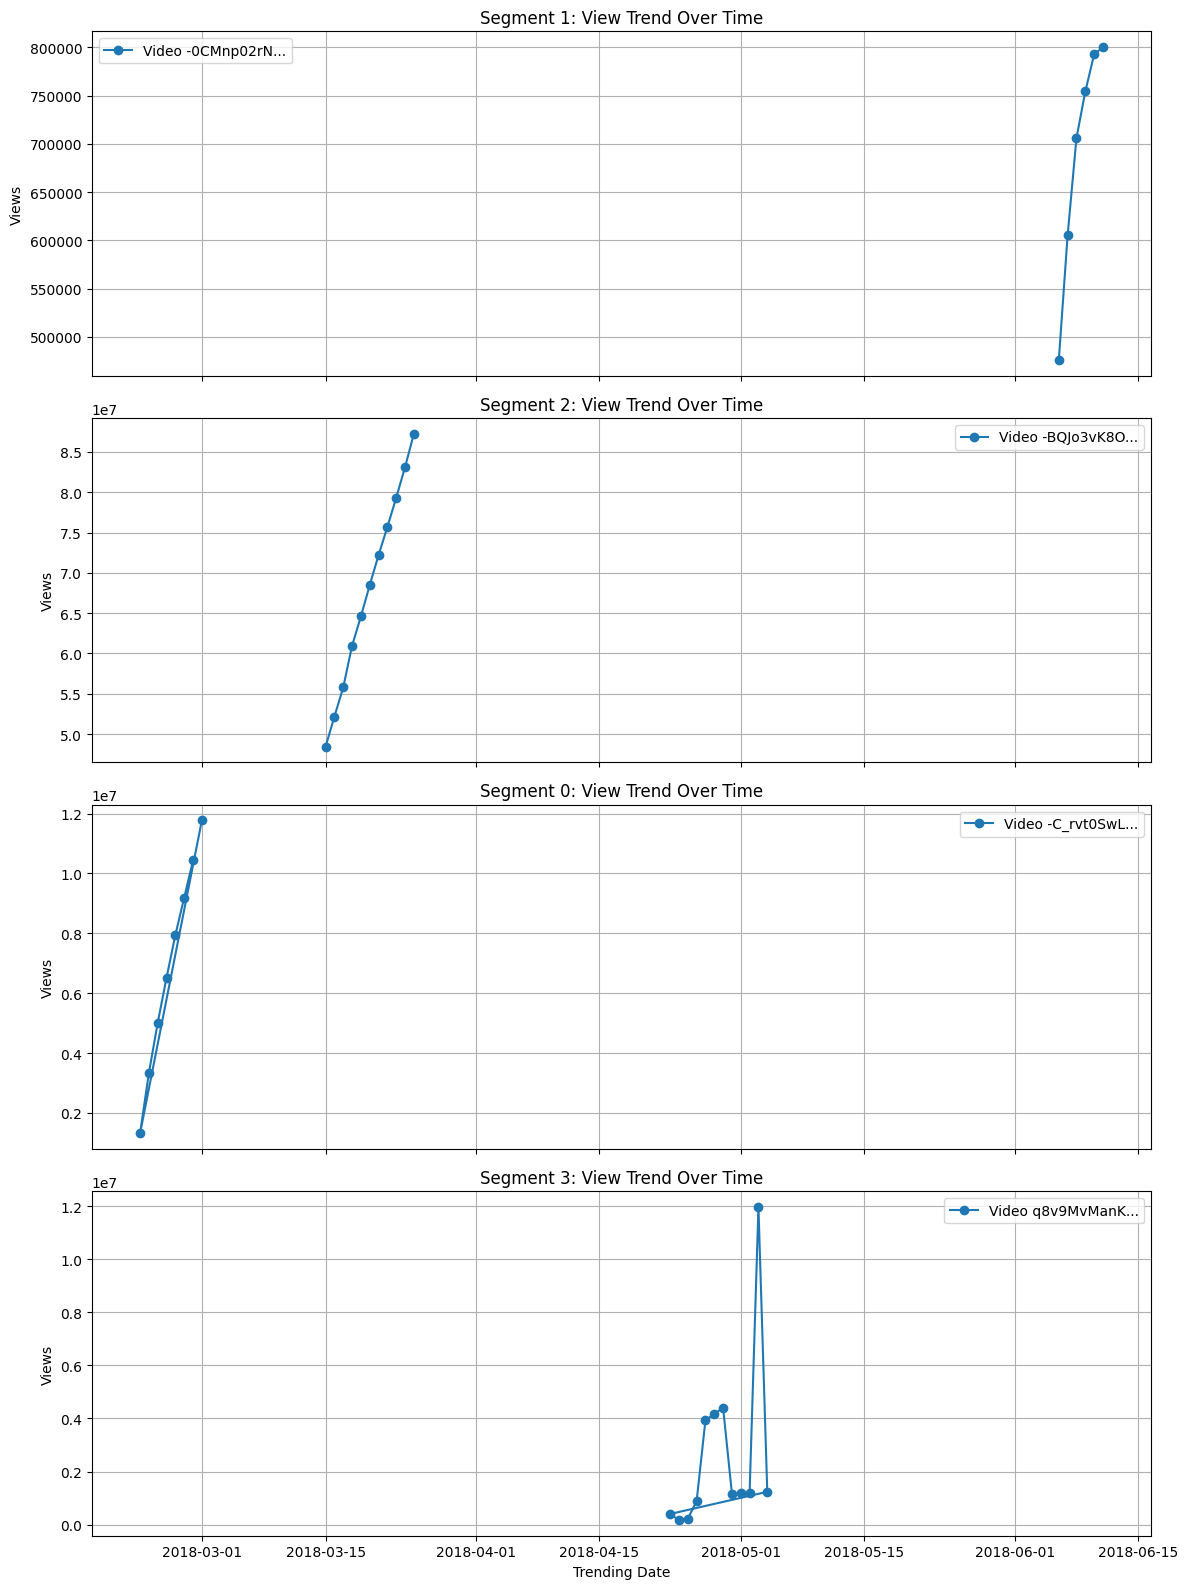

This heatmap reveals relationships between burnout features, such as how slope correlates with peak drop, aiding in understanding feature interactions.


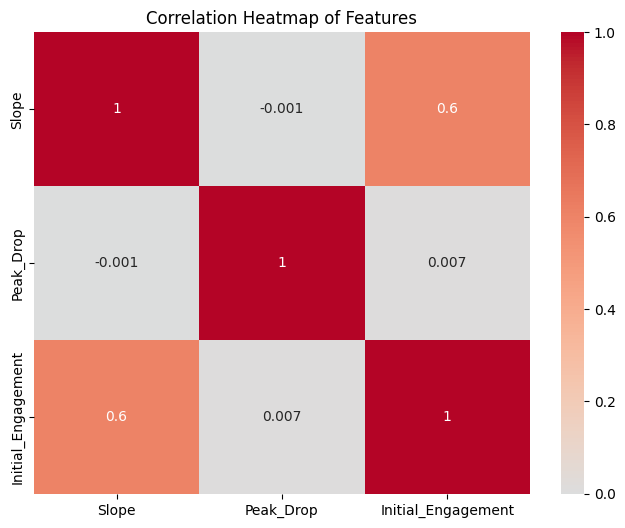

This plot evaluates clustering quality for different numbers of segments, helping confirm that the chosen K provides well-separated groups.


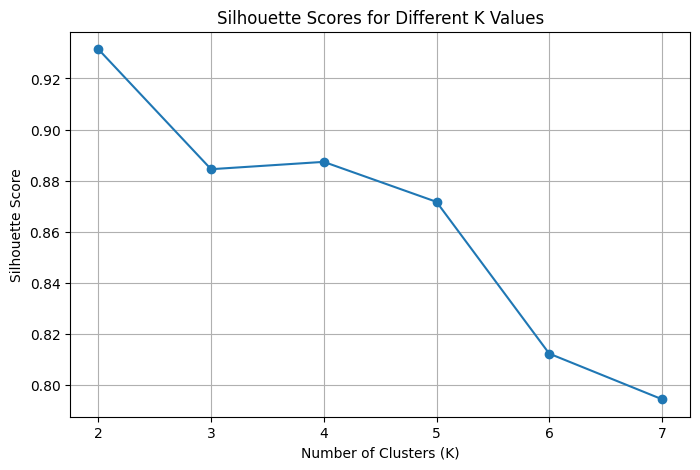

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os

# Ensure reports directory exists
reports_dir = '../reports/'
if not os.path.exists(reports_dir):
    os.makedirs(reports_dir)

# Ensure we have the data
if 'full_results' not in locals():
    # Reload if necessary
    import sys
    sys.path.append(os.path.abspath('../src'))
    import importlib
    import inference
    importlib.reload(inference)
    from inference import load_and_predict_new_data
    if 'df_raw' not in locals():
        df_raw = pd.read_csv('../Data/archive(1)/USvideos.csv')
    full_results = load_and_predict_new_data(df_raw)

# For silhouette plot, need X_scaled
if 'X_scaled' not in locals():
    # Extract features
    def extract_burnout_features(df, time_window_points=8):
        df = df.rename(columns={'trending_date': 'Observation_Date', 'video_id': 'Customer_ID', 'views': 'Engagement_Metric'})
        df['Observation_Date'] = pd.to_datetime(df['Observation_Date'], format='%y.%d.%m')
        df = df.sort_values(['Customer_ID', 'Observation_Date'])
        
        engagement_sequences = df.groupby('Customer_ID')['Engagement_Metric'].apply(
            lambda x: x.tail(time_window_points).values
        ).reset_index()
        
        feature_list = []
        
        for _, row in engagement_sequences.iterrows():
            customer_id = row['Customer_ID']
            sequence = row['Engagement_Metric']
            
            if len(sequence) < 2:
                continue

            time_points = np.arange(len(sequence))
            
            slope = np.polyfit(time_points, sequence, 1)[0]
            peak_drop = np.max(sequence) - sequence[-1] 
            initial_engagement = np.mean(sequence[:min(3, len(sequence))])

            feature_list.append({
                'Customer_ID': customer_id,
                'Slope': slope,
                'Peak_Drop': peak_drop,
                'Initial_Engagement': initial_engagement
            })

        return pd.DataFrame(feature_list).set_index('Customer_ID')
    
    df_features = extract_burnout_features(df_raw, time_window_points=8).dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_features[['Slope', 'Peak_Drop', 'Initial_Engagement']])

## Time Series Plots for Example Videos from Each Segment
# Select one example video per segment (if available)
example_videos = {}
for seg in full_results['Segment'].unique():
    seg_videos = full_results[full_results['Segment'] == seg].index
    if len(seg_videos) > 0:
        example_videos[seg] = seg_videos[0]  # Take the first one

fig, axes = plt.subplots(len(example_videos), 1, figsize=(12, 4 * len(example_videos)), sharex=True)
if len(example_videos) == 1:
    axes = [axes]

for i, (seg, video_id) in enumerate(example_videos.items()):
    # Get the time series for this video
    video_data = df_raw[df_raw['video_id'] == video_id].sort_values('trending_date')
    video_data['trending_date'] = pd.to_datetime(video_data['trending_date'], format='%y.%d.%m')
    axes[i].plot(video_data['trending_date'], video_data['views'], marker='o', label=f'Video {video_id[:10]}...')
    axes[i].set_title(f'Segment {seg}: View Trend Over Time')
    axes[i].set_ylabel('Views')
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Trending Date')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'time_series_examples.png'))

print("These time series plots show real examples of view trends for videos in each segment, illustrating how engagement evolves over time for different burnout patterns.")
plt.show()


## Correlation Heatmap
corr_matrix = full_results[['Slope', 'Peak_Drop', 'Initial_Engagement']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')

print("This heatmap reveals relationships between burnout features, such as how slope correlates with peak drop, aiding in understanding feature interactions.")
plt.savefig(os.path.join(reports_dir, 'feature_correlation_heatmap.png'))
plt.show()

## Silhouette Score Plot for Different K (Elbow-like)
k_values = range(2, 8)
sil_scores = []
for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    if len(np.unique(labels_temp)) > 1:
        sil_scores.append(silhouette_score(X_scaled, labels_temp))
    else:
        sil_scores.append(0)

plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o')
plt.title('Silhouette Scores for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

print("This plot evaluates clustering quality for different numbers of segments, helping confirm that the chosen K provides well-separated groups.")
plt.savefig(os.path.join(reports_dir, 'silhouette_scores.png'))
plt.show()